RMSE: 6.720486847226541
r2: 0.6550961415924752


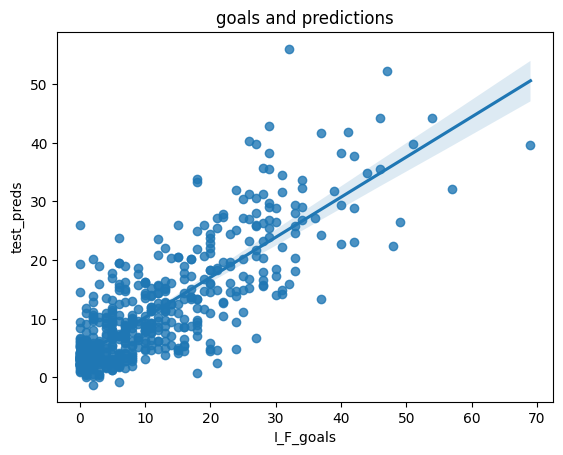

,season,playerId,name,team,I_F_goals,test_preds
5230,2023,8480073,Erik Brannstrom,OTT,3.0,3.575702
4792,2023,8475797,Jarred Tinordi,CHI,0.0,2.288084
4702,2023,8474150,Mikael Backlund,CGY,15.0,20.610123
5203,2023,8480002,Nico Hischier,NJD,27.0,30.665007
5035,2023,8478401,Pavel Zacha,BOS,21.0,18.662901
5317,2023,8481013,Jonatan Berggren,DET,2.0,10.380665
5182,2023,8479941,Justin Danforth,CBJ,10.0,6.307225
5196,2023,8479991,Jake Leschyshyn,NYR,0.0,3.008209
5236,2023,8480144,David Kampf,TOR,8.0,8.390895
4954,2023,8477506,Ryan Pulock,NYI,5.0,2.659455


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr




#Define project directory
project_directory = '/content/drive/MyDrive/puck_predictor/data'

#Seasons data
seasons = os.listdir(f"{project_directory}")

seasons = sorted(seasons, key=lambda x: int(x.split('=')[1]))

#get target seasons
target_seasons = [x for x in seasons if any(year in x for year in ['2018', '2019', '2020', '2021', '2022', '2023'])]


#get skater data
data_files = [f"{project_directory}/{data_folder}/{os.listdir(f'{project_directory}/{data_folder}')[0]}" for data_folder in target_seasons]


#dataframe creation
lst = []

for fn in data_files:
  data = pd.read_csv(fn)
  data.columns = data.columns.str.strip()
  lst.append(data)

df = pd.concat(lst, ignore_index=True)

# Filter for 'all' situation
df = df[df['situation'] == 'all']

skater_feats = ['playerId', 'season', 'name', 'team', 'icetime', 'gameScore', 'onIce_xGoalsPercentage', 'I_F_xOnGoal', 'I_F_xGoals', 'I_F_xRebounds',
'I_F_flurryScoreVenueAdjustedxGoals', 'I_F_shotsOnGoal', 'I_F_missedShots', 'I_F_shotAttempts', 'I_F_points', 'I_F_goals', 'I_F_rebounds',
'I_F_playContinuedInZone', 'I_F_savedShotsOnGoal', 'I_F_savedUnblockedShotAttempts', 'I_F_mediumDangerShots',
'I_F_scoreAdjustedShotsAttempts', 'I_F_unblockedShotAttempts', 'I_F_scoreAdjustedUnblockedShotAttempts',
'I_F_xGoals_with_earned_rebounds_scoreAdjusted', 'I_F_oZoneShiftStarts', 'OnIce_F_shotAttempts']


groupby_feats = ['season', 'playerId', 'name', 'team']

unneeded_feats = ['season', 'playerId', 'name', 'team','position','situation', 'I_F_goals']

needed_feats = [x for x in skater_feats if x not in unneeded_feats]

skater_df = (df
             .loc[:, skater_feats]
              .groupby(groupby_feats,
                        as_index = False).sum())
'''
Create linear regression plot for the correlation
between I_F_goals and the current season's features

for y in needed_feats:
  sns.regplot(data=skater_df, x='I_F_goals', y=y)
  plt.title(f"I_F_goals and {y}")
  plt.show()
'''

_df = skater_df.copy()


#go to the next season
_df['season'] = _df['season'].add(1)


# merge this back on the original qb dataframe
# specify "on=[]" so we only join on specific
# columns; specify "suffixes=()" so the duplicate
# column names get a suffix appended to them;
# specify "how='left'" so this is a left join


new_skater_df = (skater_df.merge(_df, on=['season', 'playerId', 'name', 'team'], suffixes=('', '_prev'), how='left'))

prev_needed_feats = [f"{col}_prev" for col in needed_feats]

'''
Create linear regression plot for the correlation
between I_F_goals and the previous season's features

for y in prev_needed_feats:
  sns.regplot(data=new_skater_df, x='I_F_goals', y=y)
  plt.title(f"I_F_goals and {y}")
  plt.show()
'''

target = 'I_F_goals'

model_data = (new_skater_df.dropna(subset=prev_needed_feats+[target]))

train_seasons = [2018, 2019, 2020, 2021, 2022]

train_data = model_data.loc[model_data['season'].isin(train_seasons)]
test_data = model_data.loc[model_data['season'] == 2023]


model = LinearRegression()

model.fit(train_data[prev_needed_feats], train_data[target])

test_preds = model.predict(test_data[prev_needed_feats])


test_preds = pd.Series(test_preds, index=test_data.index)

test_data = test_data.copy()
test_data['test_preds'] = test_preds


rmse = mean_squared_error(test_data[target], test_data['test_preds'])**0.5
r2 = pearsonr(test_data[target], test_data['test_preds'])[0]**2

print(f"RMSE: {rmse}\nr2: {r2}")

sns.regplot(data=test_data, x=target, y='test_preds')
plt.title('goals and predictions')
plt.show()

test_data.loc[:, ['season', 'playerId', 'name', 'team', target, 'test_preds']].sort_values(target, ascending=False).sample(10)

